In [1]:
!pip install -U matplotlib

     |████████████████████████████████| 11.5 MB 29.3 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalled matplotlib-3.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dxdata 0.30.2 requires matplotlib==3.0.3; python_version >= "3.5", but you have matplotlib 3.3.4 which is incompatible.
dxdata 0.30.2 requires numpy<=1.18.5; python_version >= "3.5", but you have numpy 1.19.4 which is incompatible.


In [2]:
import toml
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pyspark
import dxpy
import dxdata

In [3]:
with open("../config.toml") as f:
    conf = toml.load(f)

GENE = conf["GENE"]
# REFERENCE_GENOME = conf["REFERENCE_GENOME"]
# LOG_FILE = Path(conf["IMPORT"]["LOG_DIR"], f"{GENE}_results.log").resolve().__str__()

In [4]:
# Spark and Hail
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

# hl.init(sc=sc, default_reference=REFERENCE_GENOME, log=LOG_FILE)

In [37]:
def pval(x):
    if x < 0.0001:
        return "****"
    if x < 0.001:
        return "***"
    if x < 0.01:
        return "**"
    if x < 0.05:
        return "*"
    if x > 0.05:
        return ""


def pheno_search(x):
    try:
        return ukb_coding[ukb_coding.FieldID == int(x)].Field.values[0]
    except:
        # coding from https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=100605
        if x == "6150_1":
            return "Heart attack diagnosed by doctor"
        elif x == "6150_2":
            return "Angina diagnosed by doctor"
        elif x == "6150_3":
            return "Stroke diagnosed by doctor"
        elif x == "6150_4":
            return "High blood pressure diagnosed by doctor"
        elif x == "myo":
            return "myocardial disease incl. angina pectoris"
        elif x == "3005":
            return "Fracture resulting from simple fall"
        else:
            return x


def fix_df(df, TRAIT):
    if TRAIT == "BT":
        df["OR"] = np.exp(df.BETA)
        df["OR_upper"] = np.exp(df.BETA + df.SE)
        df["OR_lower"] = np.exp(df.BETA - df.SE)
        df["OR_se"] = df["OR_upper"] - df["OR_lower"]
        df["OR_se_l"] = df["OR"] - df["OR_lower"]
        df["OR_se_u"] = df["OR_upper"] - df["OR"]
    elif TRAIT == "QT":
        df.loc[:, "OR"] = df.BETA
        df.loc[:, "OR_se"] = df.SE

    df.loc[:, "Phenotype"] = df.PHENO.apply(lambda x: pheno_search(x))
    df.loc[:, "pval"] = np.power(10, -df["LOG10P"])
    df.loc[:, "pval_e"] = df.pval.apply(lambda x: f"{x:.2f}")
    df.loc[:, "pval_stars"] = df["pval"].apply(lambda x: pval(x))
    df.loc[:, "N_pos"] = (2 * df["N"] * df["A1FREQ"]).astype(int)

    return df

In [38]:
files = [
    f"file:/mnt/project/data/results/{GENE}/{file}"
    for file in os.listdir(f"/mnt/project/data/results/{GENE}")
]

ukb_coding = pd.read_csv(
    "/opt/notebooks/gogoGPCR/data/misc/Data_Dictionary_Showcase.csv",
    error_bad_lines=False,
    warn_bad_lines=False,
    quotechar='"',
)

custom_coding

In [ ]:
recode = {
    "systolic": "Systolic blood pressure",
    "diastolic": "Diastolic blood pressure",
    "diabetes": "Type 2 diabetes",
    "obesity": "Obesity",
    "blood_pressure_med": "Blood pressure medication",
    "cholesterol_med": "Cholesterol medication",
}

df = pd.read_csv(files[0], delimiter=" ", header="infer", comment="#").assign(
    SOURCE=os.path.basename(files[0])
)
df = pd.concat(
    [df]
    + [
        pd.read_csv(fp, delimiter=" ", comment="#").assign(SOURCE=os.path.basename(fp))
        for fp in files[1:]
    ],
    axis=0,
)

df.loc[:, "GENE"] = df.ID.apply(lambda x: x.split(".")[0])
df.loc[:, "MASK"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=2)[0])
df.loc[:, "AAF"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=1)[-1])
df.loc[:, "FILE"] = df.SOURCE.apply(
    lambda x: x.split("/")[-1].split("\.")[0].split("_", maxsplit=4)[2:]
)
df.loc[:, "TRAIT"] = df.FILE.apply(lambda x: x[0])
df.loc[:, "PHENO"] = df.FILE.apply(lambda x: x[-1].split(".")[0])
df = df.drop(["ID", "ALLELE0", "ALLELE1", "EXTRA", "SOURCE", "FILE", "TEST"], axis=1)
df.loc[:, "PHENO"] = df.loc[:, "PHENO"].apply(lambda x: recode.get(x, x))
df = df.loc[df["AAF"] != "singleton", :]
df.head()

In [44]:
# Set trait specific
TRAIT = "QT"

titles = {
    "BT": "Binary Traits",
    "QT": "Quantitative Traits",
}
title = titles[TRAIT]

xlabs = {"BT": "OR", "QT": "β"}
xlab = xlabs[TRAIT]

masks = df.MASK.unique()

# masks = [unique_masks[0], unique_masks[3], unique_masks[1]]

interesting_traits = {
    "QT": [
        "Diastolic blood pressure",
        "Systolic blood pressure",
        "Body mass index (BMI)",
        "Body fat percentage",
    ],
    "BT": [
        "Type 2 diabetes",
        "Obesity",
    ],
}
interesting = interesting_traits[TRAIT]

In [45]:
# Plotting options

lw = 1.3
ms = 10
height = 2 * len(interesting)

legend_elements = [
    Line2D([0], [0], color="tab:grey", marker="o", ms=ms, lw=0, label="WT-like"),
    Line2D(
        [0], [0], color="tab:orange", marker="o", ms=ms, lw=0, label="cAMP LOF only"
    ),
    Line2D([0], [0], color="tab:purple", marker="o", ms=ms, lw=0, label="Both LOF"),
]

In [46]:
df2 = df.loc[df.TRAIT.eq(TRAIT), :]
df2 = fix_df(df2, TRAIT=TRAIT)
df2 = df2.loc[df2.Phenotype.isin(interesting)]
df2

,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,GENE,MASK,AAF,TRAIT,PHENO,OR,OR_se,Phenotype,pval,pval_e,pval_stars,N_pos
1,11,113410736,0.004195,146139,0.011853,0.026909,0.194012,0.180720,DRD2,WT,0.01,QT,21001,0.011853,0.026909,Body mass index (BMI),0.659599,0.66,,1226
3,11,113410736,0.000404,146139,0.080477,0.086405,0.867482,0.453885,DRD2,LoF,0.01,QT,21001,0.080477,0.086405,Body mass index (BMI),0.351654,0.35,,117
1,11,113410736,0.004213,143970,0.031049,0.020688,2.252530,0.874855,DRD2,WT,0.01,QT,23099,0.031049,0.020688,Body fat percentage,0.133397,0.13,,1212
3,11,113410736,0.000403,143970,0.093924,0.066640,1.986460,0.799391,DRD2,LoF,0.01,QT,23099,0.093924,0.066640,Body fat percentage,0.158712,0.16,,116
1,11,113410736,0.004198,146503,0.067889,0.027327,6.171900,1.886740,DRD2,WT,0.01,QT,Diastolic blood pressure,0.067889,0.027327,Diastolic blood pressure,0.012980,0.01,*,1230
3,11,113410736,0.000403,146503,0.028824,0.087889,0.107558,0.129045,DRD2,LoF,0.01,QT,Diastolic blood pressure,0.028824,0.087889,Diastolic blood pressure,0.742942,0.74,,117
1,11,113410736,0.004198,146503,0.027842,0.025754,1.168730,0.553366,DRD2,WT,0.01,QT,Systolic blood pressure,0.027842,0.025754,Systolic blood pressure,0.279662,0.28,,1230
3,11,113410736,0.000403,146503,0.014334,0.082831,0.029948,0.064186,DRD2,LoF,0.01,QT,Systolic blood pressure,0.014334,0.082831,Systolic blood pressure,0.862609,0.86,,117


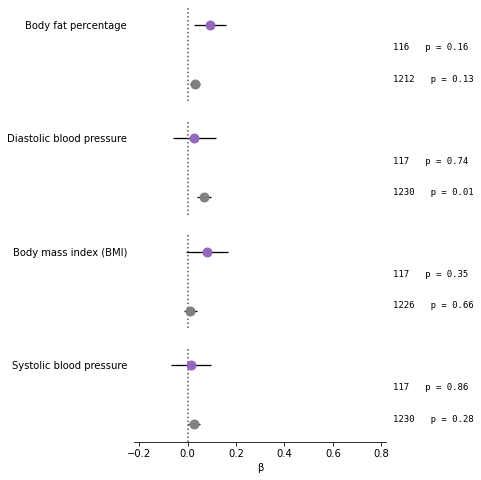

In [47]:
plt_df = (
    df2.loc[(df2.GENE == GENE)]
    .sort_values(by=["Phenotype", "AAF"], ascending=[True, False])
    .groupby(["Phenotype", "MASK"])
    .first()
    .reset_index()
)

plt_df = plt_df.loc[
    ~plt_df.Phenotype.isin(
        [
            "sev_obesity",
            "Date E66 first reported (obesity)",
            "Date I10 first reported (essential (primary) hypertension)",
            "myocardial disease incl. angina pectoris",
            "Pulse rate, automated reading",
            "Heart attack diagnosed by doctor",
            "Angina diagnosed by doctor",
            "Fracture resulting from simple fall",
            "Stroke diagnosed by doctor",
        ]
    )
]

group_by_mean = pd.DataFrame(
    {"mean": plt_df.groupby(["Phenotype"]).agg("mean")["OR"]}
).reset_index()

group_by_mean = group_by_mean.sort_values(by="mean", ascending=False).reset_index()

sorter = list(group_by_mean["Phenotype"])

plt_df.loc[:, "Phenotype"] = plt_df.loc[:, "Phenotype"].astype("category")
plt_df.loc[:, "Phenotype"].cat.set_categories(sorter, inplace=True)

plt_df = plt_df.sort_values(
    by=["Phenotype", "MASK"], ascending=[True, False]
).reset_index(drop=True)

phenotypes = plt_df.Phenotype.unique()

fig, axes = plt.subplots(nrows=len(phenotypes), sharex=True, figsize=(4, height))

for ax in range(0, len(phenotypes)):
    temp = plt_df.loc[plt_df.Phenotype.eq(phenotypes[ax]), :]
    temp = temp.loc[plt_df.MASK.isin(masks)]

    temps = [temp[temp.MASK == mask] for mask in masks]

    if TRAIT == "BT":
        xerrs = [[temp["OR_se_l"].values, temp["OR_se_u"].values] for temp in temps]

    elif TRAIT == "QT":
        xerrs = [temp["OR_se"] for temp in temps]

    axes[ax].errorbar(
        temps[0]["OR"],
        temps[0].index,
        alpha=0.99,
        xerr=xerrs[0],
        fmt="o",
        c="tab:grey",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    axes[ax].errorbar(
        temps[1]["OR"],
        temps[1].index,
        alpha=0.99,
        xerr=xerrs[1],
        fmt="o",
        c="tab:purple",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    # axes[ax].errorbar(
    #    temps[2]["OR"],
    #    temps[2].index,
    #    alpha=0.99,
    #    xerr=xerrs[2],
    #    fmt="o",
    #    c="tab:orange",
    #    ecolor="black",
    #    ms=ms,
    #    mew=0.0,
    #    mec="black",
    #    elinewidth=lw,
    # )

    ax0 = axes[ax].twinx()
    ax0.set_ylim([0.25, 3.25])
    ax0.set_yticks(
        [
            1,
            2,
        ]
    )

    y2labels = (
        temp.N_pos.astype(str)
        #    + temp.or_e.astype(str).str.ljust(5).values
        #    + ["("]
        #    + temp.lower_e.values
        #    + [","]
        #    + temp.upper_e.values
        + ["   p = "]
        + temp.pval_e.values
    )

    ax0.set_yticklabels(y2labels, fontsize=9, fontdict={"family": "monospace"})
    ax0.tick_params(right=False)
    ax0.spines["top"].set_alpha(0)
    ax0.spines["left"].set_alpha(0)
    ax0.spines["right"].set_alpha(0)
    ax0.spines["bottom"].set_alpha(0)
    ax0.grid(False)
    # axes[ax].invert_xaxis()
    # only show every 3rd yticklabel
    labels = [l if i % 3 == 0 else "" for i, l in enumerate(temp.Phenotype)]
    axes[ax].set(yticks=temp.index, yticklabels=labels[::-1])

    # axes[ax].axvline(x=0, linestyle="--", color="#4f4f4f")
    axes[ax].tick_params(left=False)

    if TRAIT == "BT":
        axes[ax].set_xlim([-0.2, 5.2])
        axes[ax].axvline(x=1, linestyle=":", color="#4f4f4f")
    elif TRAIT == "QT":
        axes[ax].set_xlim([-0.22, 0.82])
        axes[ax].axvline(x=0, linestyle=":", color="#4f4f4f")

    axes[ax].spines["top"].set_alpha(0)
    axes[ax].spines["left"].set_alpha(0)
    axes[ax].spines["right"].set_alpha(0)
    if ax != len(phenotypes) - 1:
        axes[ax].spines["bottom"].set_alpha(0)
        axes[ax].tick_params(bottom=False)

    if ax == len(phenotypes) - 1:
        axes[ax].set_xlabel(xlab)
        # ax0.legend(handles = legend_elements, loc = "lower right")
#
# axes[len(phenotypes) - 1].set_xticks([0,1,2,3,4,5,6,7,])
for ax in axes.flat:
    ax.margins(0.3)

plt.subplots_adjust(right=1)
# fig.suptitle(title)

# plt.savefig(f"/opt/notebooks/gogoGPCR/tmp/{GENE}_{TRAIT}_new.svg", dpi = 600, bbox_inches="tight", format = "svg")
plt.show()

In [18]:
plt_df["N_pos"]

0    14
1     5
2    14
3     5
4    13
5     4
6    13
7     4
Name: N_pos, dtype: int64

In [16]:
df["N_alleles"] = df["N"] * df["A1FREQ"] * 2
df

,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,GENE,MASK,AAF,TRAIT,PHENO,N_alleles
0,11,113410736,0.000047,149631,0.099278,0.934201,0.011293,0.038404,DRD2,WT,singleton,BT,2463,13.999985
1,11,113410736,0.004170,149631,0.023026,0.096862,0.056223,0.090140,DRD2,WT,0.01,BT,2463,1248.000348
2,11,113410736,0.000017,149631,0.912393,1.387560,0.432373,0.291726,DRD2,LoF,singleton,BT,2463,5.000010
3,11,113410736,0.000398,149631,0.581343,0.320565,3.288750,1.156420,DRD2,LoF,0.01,BT,2463,119.000038
0,11,113410736,0.004202,14159,0.547678,0.211060,7.121170,2.118170,DRD2,WT,0.01,BT,3005,118.999882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,11,113410736,0.000403,146503,0.065383,0.089304,0.536030,0.333405,DRD2,LoF,0.01,QT,pulse,117.999962
0,11,113410736,0.000048,146503,0.082061,0.240393,0.116527,0.134996,DRD2,WT,singleton,QT,Systolic blood pressure,14.000002
1,11,113410736,0.004198,146503,0.027842,0.025754,1.168730,0.553366,DRD2,WT,0.01,QT,Systolic blood pressure,1230.001097
2,11,113410736,0.000017,146503,0.317316,0.402246,0.622303,0.366337,DRD2,LoF,singleton,QT,Systolic blood pressure,5.000001


In [ ]:
pheno_search